In [2]:
import os
import pickle
import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pydicom.pixel_data_handlers.util import apply_voi_lut
summary_dicom_path = "summary_dicom.pkl"
summary_anot_path = "summary_anot.pkl"


In [3]:
df1 = pd.read_pickle(summary_dicom_path)
df2 = pd.read_pickle(summary_anot_path)

#1.2.840.113619.2.388.57473.14165493.13177.1591830725.678


In [4]:
# df2 = df2["seriesuid"].value_counts()
path = []
for key,value in enumerate(df2["seriesuid"]):
    path.append(value)
path = pd.Series(path).drop_duplicates()
# print(list(path))

index = 18
chosen_series_uid = list(path)[index]
print(chosen_series_uid)

1.2.840.113619.2.388.57473.14165493.12759.1602462768.753


In [7]:
df1_ex = df1[df1.SeriesInstanceUID == chosen_series_uid].sort_values(by = ["SliceLocation"])
df2.head()

,date,patientid,patientPid,diagnosis,sessionid,type_anot,annotation,scope,unit,timestamp,imageuid,seriesuid,studyuid,tag,points
0,2020-09-09 07:30:39,784667,YC21,"[908910, 908912]",BSDIEP,local,20,,mm,1610884981375,,1.2.840.113619.2.388.57473.14165493.12654.1599...,1.2.840.113619.6.388.1017747398342806435283613...,[Mass/Nodule],"[[-12.035799980164, -70.509002685547, -40.1687..."
1,2020-09-09 07:30:39,784667,YC21,"[908910, 908912]",BSDIEP,local,20,,mm,1610885017001,,1.2.840.113619.2.388.57473.14165493.12654.1599...,1.2.840.113619.6.388.1017747398342806435283613...,[Cerebral edema],"[[-46.030101776123, -54.770900726318, -36.5686..."
2,2020-09-09 07:30:39,784667,YC21,"[908910, 908912]",BSDIEP,local,20,,mm,1610885075681,,1.2.840.113619.2.388.57473.14165493.12654.1599...,1.2.840.113619.6.388.1017747398342806435283613...,[Midline shift],"[[-0.074838802218437, -44.698501586914, -18.56..."
3,2020-09-09 07:30:39,784667,YC21,"[908910, 908912]",BSDIEP,global,-1,series,,1610885136683,,1.2.840.113619.2.388.57473.14165493.12654.1599...,1.2.840.113619.6.388.1017747398342806435283613...,[Meningioma],None
4,2020-06-11 09:48:45,758809,23 BHK,"[841808, 841810]",BSDIEP,local,20,,mm,1607483610460,,1.2.840.113619.2.388.57473.14165493.13177.1591...,1.2.840.113619.6.388.1067388807510514152787160...,[Mass/Nodule],"[[-1.3457000255585, -22.289400100708, -15.3137..."


In [389]:
study_uid = df1_ex.iloc[0]["StudyInstanceUID"]
print(f"StudyUID: {study_uid}")

StudyUID: 1.2.840.113619.6.388.144165236519345438437589497640968510568


In [390]:
# extract unique z from annotation
points = list(df2[df2.seriesuid == chosen_series_uid]["points"])[0]
for point in points:
    print(point)
z_anot = []
xy3d = []
for point in points:
    z_anot.append(point[2])
z_anot = pd.Series(z_anot).drop_duplicates()
z_anot


[-12.616100311279, 7.4660701751709, 23.806900024414]
[6.2695999145508, 7.4660701751709, 23.806900024414]
[6.2695999145508, 21.315599441528, 23.806900024414]
[-12.616100311279, 21.315599441528, 23.806900024414]
[-17.022800445557, 1.1708199977875, 34.606899261475]
[10.676300048828, 1.1708199977875, 34.606899261475]
[10.676300048828, 23.204200744629, 34.606899261475]
[-17.022800445557, 23.204200744629, 34.606899261475]
[-18.911399841309, -2.6063199043274, 47.206901550293]
[12.564800262451, -2.6063199043274, 47.206901550293]
[12.564800262451, 21.315599441528, 47.206901550293]
[-18.911399841309, 21.315599441528, 47.206901550293]


0    23.806900
4    34.606899
8    47.206902
dtype: float64

In [412]:
z_meta_slice = [float(value) for key,value in enumerate(df1_ex["SliceLocation"])]
z_meta_imgpose = sorted([float(value[2])  for key,value in enumerate(df1_ex["ImagePositionPatient"])])

In [457]:
# extract slice contain upper, lower and middle annotation point
match_z = []
for z in z_anot:
    print(f"Match: {z}")
    abs_store = []
    abs_store = [[index,np.abs(z - z_new)] for index,z_new in enumerate(z_meta_imgpose) if np.sign(z) == np.sign(z_new)]
    abs_store =  sorted(abs_store, key=lambda x:x[1])
    match_z.append(abs_store[0])
print("Match slice (row index) and its error")
print(match_z)


Match: 23.806900024414
Match: 34.606899261475
Match: 47.206901550293
Match slice (row index) and its error
[[3, 2.3749999755860003], [4, 1.4475992614749984], [6, 0.09280155029299664]]


In [458]:
# for i in range(len(df1_ex.index)):
#     print(df1_ex.iloc[i]["ImageOrientationPatient"])
print("Image orientation does not affect")

Image orientation does not affect


In [459]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

In [460]:
root = "//media/tungthanhlee/DATA/brain-mri-tumor-dicom-masked"
study_folder = os.path.join(root, study_uid)

extracted_path = []
xyroot = []
for i in match_z:
    extracted_path.append( os.path.join(study_folder, df1_ex.iloc[i[0]]["NameFileXML"]))
    xyroot.append(df1_ex.iloc[i[0]]["ImagePositionPatient"])
print("Image path:")
print(extracted_path)

imgs = []
for i in extracted_path:
    imgs.append(read_xray(i))

Image path:
['//media/tungthanhlee/DATA/brain-mri-tumor-dicom-masked/1.2.840.113619.6.388.144165236519345438437589497640968510568/1.2.840.113619.2.388.57473.14165493.12076.1602462820.651.dcm', '//media/tungthanhlee/DATA/brain-mri-tumor-dicom-masked/1.2.840.113619.6.388.144165236519345438437589497640968510568/1.2.840.113619.2.388.57473.14165493.12076.1602462820.652.dcm', '//media/tungthanhlee/DATA/brain-mri-tumor-dicom-masked/1.2.840.113619.6.388.144165236519345438437589497640968510568/1.2.840.113619.2.388.57473.14165493.12076.1602462820.654.dcm']


In [461]:
# save only x,y 
xy3d = [[point[0], point[1]] for point in points]
xy3d

[[-12.616100311279, 7.4660701751709],
 [6.2695999145508, 7.4660701751709],
 [6.2695999145508, 21.315599441528],
 [-12.616100311279, 21.315599441528],
 [-17.022800445557, 1.1708199977875],
 [10.676300048828, 1.1708199977875],
 [10.676300048828, 23.204200744629],
 [-17.022800445557, 23.204200744629],
 [-18.911399841309, -2.6063199043274],
 [12.564800262451, -2.6063199043274],
 [12.564800262451, 21.315599441528],
 [-18.911399841309, 21.315599441528]]

In [462]:
pixel_spacing =  float(df1_ex.iloc[0]["PixelSpacing"][0])
delta = np.sqrt(2*((pixel_spacing/2)**2))
print(f"Delta: {delta}")
xy_root_new = [[float(p[0]) - delta,float(p[1]) - delta] for p in xyroot]
# xy_root_new = [[float(p[0]) ,float(p[1]) ] for p in xyroot]
print(xy_root_new)

Delta: 0.35906882348652885
[[-132.73906882348652, -117.55806882348652], [-132.17706882348654, -117.56206882348653], [-131.05406882348652, -117.57006882348652]]


In [463]:
xy2d = []
cur_im = []
count1 = 1
count2 = 0
while count1 <  len(xy3d)+1:

    new_p = [(xy3d[count1-1][0] - xy_root_new[count2][0])/pixel_spacing,(xy3d[count1-1][1] - xy_root_new[count2][1])/pixel_spacing]
    # xy2d.append(new_p)
    cur_im.append(new_p)
    # print(new_p)
    if count1 % 4 == 0:
        xy2d.append(cur_im)
        cur_im = []
        count2 += 1
    count1 += 1
xy2d

[[[236.55566859434327, 246.2074419036184],
  [273.74688605363787, 246.2074419036184],
  [273.74688605363787, 273.4810324242113],
  [236.55566859434327, 273.4810324242113]],
 [[226.77091055125942, 233.81821351176453],
  [281.3181742266927, 233.81821351176453],
  [281.3181742266927, 277.20809288719084],
  [226.77091055125942, 277.20809288719084]],
 [[220.8402303705741, 226.39572453556343],
  [282.82565790850236, 226.39572453556343],
  [282.82565790850236, 273.50466377513686],
  [220.8402303705741, 273.50466377513686]]]

In [468]:

# save as xywh
plot_point = []
for cur_im in xy2d:
    x= [ p[0] for p in cur_im]
    y = [ p[1] for p in cur_im ]
    bottomleftx = min(x)
    bottomlefty = min(y)
    height = max(y) - min(y)
    width = max(x) - min(x)
    out = [bottomleftx, bottomlefty, width, height]
    plot_point.append(out)
plot_point

[[236.55566859434327,
  246.2074419036184,
  37.19121745929459,
  27.273590520592933],
 [226.77091055125942,
  233.81821351176453,
  54.54726367543327,
  43.38987937542632],
 [220.8402303705741,
  226.39572453556343,
  61.985427537928274,
  47.10893923957343]]

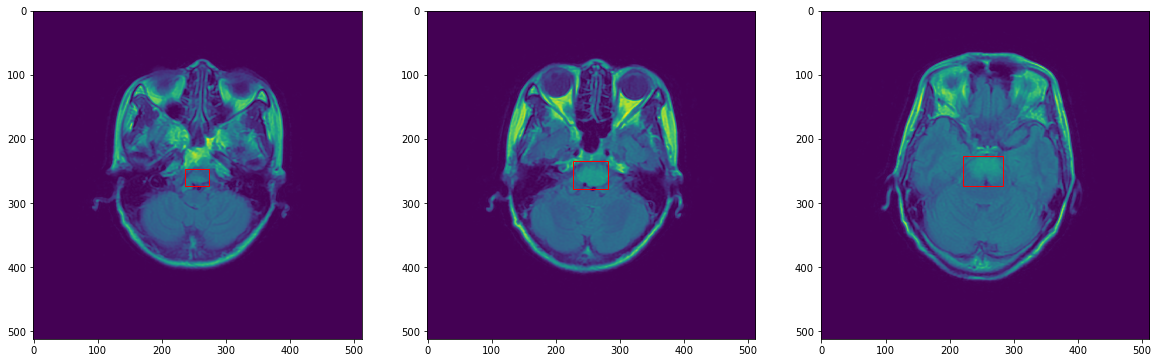

In [465]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(7)
fig.set_figwidth(20)


ax1.imshow(imgs[0])
rect1 = patches.Rectangle(plot_point[0][0], plot_point[0][1], plot_point[0][2], plot_point[0][3], linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect1)
ax2.imshow(imgs[1])
rect2 = patches.Rectangle(plot_point[1][0], plot_point[1][1], plot_point[1][2], linewidth=1, edgecolor='r', facecolor='none')
ax2.add_patch(rect2)
ax3.imshow(imgs[2])
rect3 = patches.Rectangle(plot_point[2][0], plot_point[2][1], plot_point[2][2], linewidth=1, edgecolor='r', facecolor='none')
ax3.add_patch(rect3)
fig.savefig(f"test_im/{study_uid}-{chosen_series_uid}-2.jpg")

In [469]:
for i in plot_point:
    print(i)

[236.55566859434327, 246.2074419036184, 37.19121745929459, 27.273590520592933]
[226.77091055125942, 233.81821351176453, 54.54726367543327, 43.38987937542632]
[220.8402303705741, 226.39572453556343, 61.985427537928274, 47.10893923957343]
